# 信用债违约前后交易信号识别

## 1.导入外部库

In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import errno
import datetime as dt
plt.rcParams["figure.figsize"] = (16,9)
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
from matplotlib import font_manager
fontP = font_manager.FontProperties()
fontP.set_family('SimHei') # 这里设定导出图片的字体
fontP.set_size(14) # 这里设定图片中字体的字号

## 2.功能函数

<style>
table th:first-of-type {
    width: 20%;
}
table th:nth-of-type(2) {
    width: 50%;
}
table th:nth-of-type(3) {
    width: 30%;
}
</style>

| 函数名称| 参数解释和作用 | 使用实例 |
| ----| ---- | ---- |
| ***data_import(company_name)***  | 用于导入万得**F9深度资料——二级成交**中的成交数据，***company_name*** 填入文件名即可 |***Aoyuan = data_import(二级成交-奥园集团有限公司(近一年))***|
| ***plot_data_cleaning(company_df, ticker)***  | 用于清理***data_import***刚刚导入的数据，***company_df***是导入的数据，***ticker***是具体的债券名称 |***AY2001 = plot_data_cleaning(Aoyuan, "20奥园01")***|
|  ***frq_count(company_df)***   | 由于万得**F9深度资料——二级成交**中的成交数据是该主体过去一年所有债券的成交数据，该函数用于显示各个债券的成交笔数 | ***frq_count(Aoyuan)*** |
|  ***data_import_singe_name(company_name)***  | 用于导入万得在**单只券行情界面--历史成交中**的成交所有数据，***company_name*** 填入债券名即可  | ***AY2001_all = data_import_singe_name("20奥园01")*** |
|  ***volume_distribution(data)***  | 用于生成单只债券交易量的时间累积分布图，***data*** 填入债券名即可 | ***volume_distribution("20奥园01")*** |
|  ***plot_deviation_with_mark(data)***  | 用于生成单只债券成交历史价格和中债估值的偏离图像，***data*** 填入债券名即可 | ***plot_deviation_with_mark("20奥园01")*** |
|  ***plot_data_cleaning_single_name(single_name_df,exchange)***  | 用于清理***data_import_single_name***刚刚导入的数据，***single_name_df***是导入单支债券的历史数据，***exchange***是具体的交易平台名称，其中“Both”是既有上证固收，也有交易所竞价成交，“Only”是仅有交易所成交数据，“No”表示交易场所在CFETS | ***plot_data_cleaning_single_name(AY2001,"Both")***  |
| ***make_pattern_graph(dataset,risk_level,ticker_name,use_YTM,use_volume,std_plot)*** | 用于生成主体量价关系图，dataset即数据来源，是万得**F9深度资料——二级成交**中的成交数据是该主体过去一年所有债券的成交数据，risk_level是债券90块钱时的收益率水平，ticker_name是具体的债券名称，use_YTM是是否使用YTM作为价格画图，False则会使用实际债券的价格，use_volume为True时，则会使用成交量数据画图，否则会使用成交笔数画图，std_plot为True时，则会画出每日成交最高价/最低价的移动标准差曲线 | ***make_pattern_graph(Aoyuan,12,"20奥园01",use_YTM,use_volume,std_plot)*** |
| ***make_pattern_graph_single(dataset,risk_level,ticker_name,exchange_name,use_YTM,std_plot)*** | 用于生成万得在**单只券行情界面--历史成交中**的成交所有历史数据的量价图，dataset即数据来源，risk_level是债券90块钱时的收益率水平，ticker_name是具体的债券名称，use_YTM是是否使用YTM作为价格画图，False则会使用实际债券的价格，use_volume为True时，则会使用成交量数据画图，否则会使用成交笔数画图，std_plot为True时，则会画出每日成交最高价/最低价的移动标准差曲线 | ***make_pattern_graph_single(AY2001,12,"20奥园01","Both",use_YTM=True,std_plot=False)*** |

In [22]:
# utility functions
today = str(dt.date.today())

def path_exists_handle(path):
    try:
        os.mkdir(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def mk_dir(name):
    directory = today
    parent_dir = r'C:\Users\' # 在这里改成自己的路径
    path = os.path.join(parent_dir,directory)
    path_exists_handle(path)

    path = os.path.join(path,name)
    path_exists_handle(path)
    return path

def data_import(company_name):
    file_name = "data/Wind/{}.xlsx"
    df = pd.read_excel(file_name.format(company_name),parse_dates=True,index_col="交易日期")[:-2]
    df = df.iloc[::-1]
    df.index = pd.to_datetime(df.index)
    tickers = df["债券名称"].unique() # an array list to export all distinct tickers
    places = df["成交来源"].unique()
    return df, tickers, places

def frq_count(company_df):
    display(company_df["债券名称"].value_counts())

def plot_data_cleaning(company_df, ticker):
    ticker_data = company_df[company_df["债券名称"]==ticker]
    ticker_data = ticker_data[["债券名称","成交来源","加权YTM","加权价","成交笔数","成交量(万)","成交金额(万元)",
                             '中债估值(行权/到期)', '中证估值(行权/到期)',"最高","最低"]]
    plot_data = ticker_data[["加权YTM","加权价","成交量(万)","中债估值(行权/到期)","成交来源","成交笔数","最高","最低"]]
    #----------------------------NOTICE------------------------------------------#
    plot_data = plot_data.replace("--",0) # <set unkonwn trade volume and size to 0, both for 成交笔数 and 成交量>
    #----------------------------NOTICE------------------------------------------#
    plot_data["加权YTM"] = plot_data["加权YTM"].astype(float)
    plot_data["加权价"] = plot_data["加权价"].astype(float)
    plot_data["成交笔数"] = plot_data["成交笔数"].astype(int)
    plot_data["成交量(万)"] = plot_data["成交量(万)"].astype(float)
    plot_data["最高"] = plot_data["最高"].astype(float)
    plot_data["最低"] = plot_data["最低"].astype(float)
    plot_data["中债估值(行权/到期)"] = plot_data["中债估值(行权/到期)"].str.split('/',expand=True).astype(float)
    return plot_data,ticker_data

def make_pattern_graph(dataset,risk_level,ticker_name,use_YTM=True,use_volume=True,std_plot=True):
    fig, ax = plt.subplots()
    if use_YTM == True:
        value = "加权YTM"
        ax.plot(dataset["加权YTM"],marker='o',linestyle='none',label="VWAP YTM")
        if std_plot == True:
            ax.plot((dataset["最高"] - dataset["最低"]).rolling(5).std(),color="#78f27e",label="Rolling Price Spread Std")
        plt.ylabel("Volume Weighted YTM")
    else:
        risk_level = 90
        value = "加权价"
        ax.plot(dataset["加权价"],marker='o',linestyle='none',label="VWAP Price")
        plt.ylabel("Volume Weighted Price")
    
    plt.axhline(y=risk_level, color='#9e1010', linestyle='-',alpha=0.5,label="RMB 90") 
    plt.legend(loc="upper left")
    ax2=ax.twinx()
    
    if use_volume == True:
        ax2.bar(dataset.index,dataset["成交量(万)"],color="k",label="Trade Volume")
        plt.ylabel("Trade Volume")
    else:
        ax2.bar(dataset.index,dataset["成交笔数"],color="k",label="Trade Numbers")
        plt.ylabel("Trade Numbers")
    plt.legend(loc="upper right")
    
    brokers_trade =  dataset[dataset["成交来源"]=="货币中介"]
    brokers_dt = list(zip(brokers_trade.index,brokers_trade[value]))
    SH_trade =  dataset[dataset["成交来源"]=="上证固收"]
    SH_dt = list(zip(SH_trade.index,SH_trade[value]))
    Cpt_trade =  dataset[dataset["成交来源"]=="交易所竞价"]
    Cpt_dt = list(zip(Cpt_trade.index,Cpt_trade[value]))
    
    # to annotate the venues
    style = dict(size=10, color='r')
    for date in brokers_dt:
        ax.text(date[0], date[1], "B", **style) # Brokers 中介成交
    for date in SH_dt:
        ax.text(date[0], date[1], "S", **style) # SH 上证固收
    for date in Cpt_dt:
        ax.text(date[0], date[1], "J", **style) # J 交易所竞价
    # All else: CFETS

    fig.suptitle('Trade Patterns for '+ticker_name,fontproperties=fontP)
    parent_path = mk_dir('Trade Patterns')
    sub_path = 'Trade Patterns for '+ticker_name+'.png'
    path = os.path.join(parent_path,sub_path)
    fig.savefig(path)
    return None

# 成交量 cumsum 辅助看一下 distribution
def volume_distribution(data):
    data_cumsum = data.copy()
    data["Volume_CumSum"] = (data["成交量(万)"].cumsum())/(data["成交量(万)"].sum())
    data["Number_CumSum"] = (data["成交笔数"].cumsum())/(data["成交笔数"].sum())
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
    ax1.plot(data["Volume_CumSum"])
    ax1.set_title("Trade Volume")
    ax2.plot(data["Number_CumSum"])
    ax2.set_title("Trade Numbers")
    return None

# ---------------------------------------
# For single name's historical data
# ---------------------------------------
def data_import_singe_name(company_name):
    file_name = "data/Wind/Single Names/{}历史收盘.xlsx"
    df = pd.read_excel(file_name.format(company_name),parse_dates=True,index_col="日期")[:-2]
    df = df.iloc[::-1]
    df.index = pd.to_datetime(df.index)
    return df

def plot_data_cleaning_single_name(single_name_df,exchange):
    if exchange == "No":
        # then it's trdaed in CFETS
        cols = ["净价(交易中心)","收盘价(交易中心)","成交量(亿)","最高","最低","中债估值(YTM)","中债估值(净价)"]
        plot_data = single_name_df[cols]
        for col_name in cols:
            plot_data[col_name] = plot_data[col_name].astype(float)
        plot_data = plot_data[plot_data["净价(交易中心)"].notna()]
        return plot_data
    elif exchange == "Both":
        # data is recorded by Wind both as E竞价 and E固收
        mark = ["中债估值(净价)","中债估值(YTM)"]
        Cols_J = ["收盘价(E竞价)","YTM(E竞价)","成交金额(E竞价)"]
        Cols_GS = ["收盘价(E固收)","YTM(E固收)","成交金额(E固收)"]
        Cols = Cols_J + Cols_GS + mark
        plot_data = single_name_df[Cols]
        for col_name in Cols:
            plot_data[col_name] = plot_data[col_name].astype(float)
            
        plot_data_J = plot_data[Cols_J+mark]
        plot_data_J = plot_data_J[plot_data_J['收盘价(E竞价)'].notna()]
        
        plot_data_GS = plot_data[Cols_GS+mark]
        plot_data_GS = plot_data_GS[plot_data_GS['收盘价(E固收)'].notna()]
        return plot_data_J, plot_data_GS
    elif exchange == "Only":
        # data is recorded by Wind as only "交易所"
        cols = ["均价","均价YTM","成交金额","中债估值(净价)","中债估值(YTM)"]
        plot_data = single_name_df[cols]
        for col_name in cols:
            plot_data[col_name] = plot_data[col_name].astype(float)
        plot_data = plot_data[plot_data['均价'].notna()]
        return plot_data

def make_pattern_graph_single(dataset,risk_level,ticker_name,exchange_name,use_YTM=True,std_plot=False):
    fig, ax = plt.subplots()
    if use_YTM == True:
        ax.plot(dataset.iloc[:,1],marker='o',linestyle='none',label="Closing YTM")
        if std_plot == True:
            ax.plot((dataset["最高"] - dataset["最低"]).rolling(5).std(),color="#78f27e",label="Rolling Price Spread Std")
        plt.ylabel("Closing YTM")
    else:
        risk_level = 90
        ax.plot(dataset.iloc[:,0],marker='o',linestyle='none',label="Closing Price")
        ax.plot(dataset["中债估值(净价)"],label="CCDC Mark")
        plt.ylabel("Closing Price")
    plt.axhline(y=risk_level, color='#9e1010', linestyle='-',alpha=0.5,label="RMB 90") 
    plt.legend(loc="upper left")
    ax2=ax.twinx()
    ax2.bar(dataset.index,dataset.iloc[:,2],color="k",label="Trade Volume")
    plt.ylabel("Trade Volume")
    plt.legend(loc="upper right")
    fig.suptitle('Trade Patterns for '+ticker_name+" at "+exchange_name,fontproperties=fontP)
    parent_path = mk_dir('Trade Patterns Single Name')
    sub_path = 'Trade Patterns for '+ticker_name+" at "+exchange_name+'.png'
    path = os.path.join(parent_path,sub_path)
    fig.savefig(path)
    return None

def plot_deviation_with_mark(new_plot_data):
    fig, ax = plt.subplots()
    ax.plot(new_plot_data["收盘价(交易中心)"].rolling(5).mean(),label="Closing YTM")
    ax.plot(new_plot_data["中债估值(YTM)"],label="CCDC Mark")
    plt.legend()
    return None

## 3. 策略模块函数

|  函数名称 | 参数解释和作用 | 使用实例 |
|  ----  | ----  | ---- |
| ***volume_MA(df,day_num1,day_num2,long_data = False,platform="None")***  | 成交量MACD策略，并给出实际的图片和信号，df参数即为个券历史成交数据,day_num1和day_num2为移动平均的天数,long_data为True，则选择的是万得在单只券行情界面--历史成交中的成交所有历史数据，否则则是万得F9深度资料——二级成交中的成交数据,platform则是该数据发生的场所，一般填入“E固收”或者“E竞价” |***volume_MA(AY2001,10,30,True,"E固收")***|
| ***turn_over_plot(df,size,platform)*** | 用于生成单券换手率变化的图像，df是导入的单券历史成交数据，size是目前该券仍在流通的数量，platform是改券交易的场所，有"E固收"，"E竞价","交易所"等选项 | ***turn_over_plot(AY2001,25.4,"E固收")***  |
| ***YTM_consec_incre(data,bp,price_threshold,long_data = False,platform="None")***  | YTM连续小幅上升策略，并给出实际的图片和信号，data参数即为个券历史成交数据,bp为人为设定的YTM每日连续涨跌值,threshold则为设定的最低卖出价格门槛，long_data为True，则选择的是万得在单只券行情界面--历史成交中的成交所有历史数据，否则则是万得F9深度资料——二级成交中的成交数据,platform则是该数据发生的场所，一般填入“E固收”或者“E竞价” |***YTM_consec_incre(AY2001,0.05,70,True,"E固收")***|
| ***YTM_consec_decre(data,bp,price_threshold,long_data = False,platform="None")***  | YTM连续小幅下降策略，并给出实际的图片和信号，data参数即为个券历史成交数据,bp为人为设定的YTM每日连续涨跌值,threshold则为设定的最高买回价格门槛，long_data为True，则选择的是万得在单只券行情界面--历史成交中的成交所有历史数据，否则则是万得F9深度资料——二级成交中的成交数据,platform则是该数据发生的场所，一般填入“E固收”或者“E竞价” |***YTM_consec_incre(AY2001,0.05,80,True,"E固收")***|
| ***semi_mon_steps_plt(data,long_data = False,platform="None")***  | 辅助判断YTM小幅上升/下降的阶梯图，data参数即为个券历史成交数据,long_data为True，则选择的是万得在单只券行情界面--历史成交中的成交所有历史数据，否则则是万得F9深度资料——二级成交中的成交数据,platform则是该数据发生的场所，一般填入“E固收”或者“E竞价” |***semi_mon_steps_plt(AY2001,True,"E固收")***|
| ***rolling_vol(data,ticker_name,days,warning=False)***  | 成交价格波动率，并生成图片和信号，data参数即为个券历史成交数据,ticker_name为具体的债券名称，days为移动波动率的天数，warning为信号开关，若为True，则会在波动率连续上升时给出卖出信号，若为False，则不给出信号 |***rolling_vol(AY2001,“20奥园01”,5,True)***|
| ***deviation_from_CCDC(plot_data,single_day_dev_price=1.5)***  | 偏离中债估值指标，并生成图片和信号，plot_data参数即为个券历史成交数据,single_day_dev参数为每天能够允许该券成交价格偏离中债估值的最大值，当该券的成交价格连续5天偏离中债估值且偏离程度不断扩大，或者单日偏离价格大于设定的single_day_dev_price（默认1.5元）的时候，函数会发出卖出信号 |***deviation_from_CCDC(AY2001,1.5)***|
| ***dev_buy_back(data,signal=True)***  | 当价格分歧指数（成交最高价-最低价）五天移动标准差回归到最高水平的一半时，函数会发出重新买回信号，data参数即为个券历史成交数据（万得F9深度资料——二级成交中的提取出的个券成交数据），signal是信号开关，为True时，则会在图中给出买回信号。 |***dev_buy_back(AY2001,signal=True)***|
| ***plot_big_order(data,number)***  | 标识出目前为止最大的均单成交日期，data参数即为个券历史成交数据，number则是最大的n日均单成交日期 |***plot_big_order(AY2001,5)***|
| ***discount_analysis(dates, dispaly_number=15, filter_rf_bonds=True)***  | 计算质押式回购折现率的变化，dates是日期列表，需要手动赋值输入，display_number是最终显示的变动率从大到小的排名，默认显示15名，filter_rf_bonds是是否需要过滤掉利率债和准利率债的开关，True则会在最终的结果中过滤掉利率债的质押式回购折现率的变动 | ***dates = ["20211208","20211207","20211206","20211203","20211202"] discount_analysis(dates, dispaly_number=15, filter_rf_bonds=True)*** 

In [23]:
# Analysis and Strategy Functions
# The Rookie Signal - Volume MA Strategy
def volume_MA(df,day_num1,day_num2,long_data = False,platform="None"):
    df = df.copy()
    num_1 = str(day_num1)
    num_2 = str(day_num2)
    if long_data == False:
        volume_name = "成交量(万)"
        yield_name = "加权YTM"
    else:
        volume_name = "成交金额("+platform+")"
        yield_name = "YTM("+platform+")"
    df["成交量(万)MA"+num_1] = df[volume_name].rolling(day_num1).mean()
    df["成交量(万)MA"+num_2] = df[volume_name].rolling(day_num2).mean()
    df['Bid Signal'] = 0.0
    df['Bid Signal'] = np.where(df['成交量(万)MA'+num_1]>df['成交量(万)MA'+num_2],1,0)
    df['Position'] = df['Bid Signal'].diff()

    fig, ax = plt.subplots()
    ax.plot(df["成交量(万)MA"+num_1],label="Trade Volume MA"+num_1,color="k")
    ax.plot(df["成交量(万)MA"+num_2],label="Trade Volume MA"+num_2,color="r")
    
    plt.plot(df[df['Position'] == 1].index, df['成交量(万)MA'+num_1][df['Position'] == 1], 
         'v', markersize = 10, color = 'g', label = 'Exit')
    plt.legend(loc="upper left")
    ax2=ax.twinx()
    ax2.plot(df[yield_name],marker='o',linestyle='none',label="YTM")

    plt.legend("upper right")
    return df[df['Position'] == 1].index

# scale 一下成交量，用换手率去看 - plot 换手率以及分位数水平
# size 是债券的流通量，单位是亿

def turn_over_plot(df,size,platform):
    if platform == "交易中心":
        df["Turnover"] = df["成交量(亿)"]/size
    elif platform == "CFETS":
        df["Turnover"] = (df["成交量(万)"]/10000)/size
    else:
        platform = "成交金额("+platform+")"
        df["Turnover"] = (df[platform]/10000)/size
    quantile_25 = df["Turnover"].quantile(0.25)
    quantile_50 = df["Turnover"].quantile(0.5)
    quantile_75 = df["Turnover"].quantile(0.75)
    quantile_90 = df["Turnover"].quantile(0.9)
    
    fig, ax = plt.subplots()
    ax.plot(df.iloc[:,1],marker='o',linestyle='none',label="YTM")
    
    ax2=ax.twinx()
    ax2.plot(df["Turnover"],color="k",label="Trade Turnover Rate")
    plt.axhline(y=quantile_25, color='#60B40B', linestyle='-',alpha=0.5,label="25% Quantile") 
    plt.axhline(y=quantile_50, color='#FF5733', linestyle='-',alpha=0.5,label="50% Quantile") 
    plt.axhline(y=quantile_75, color='#FFC333', linestyle='-',alpha=0.5,label="75% Quantile")
    plt.axhline(y=quantile_90, color='#9D1616', linestyle='-',alpha=0.5,label="90% Quantile") 
    plt.legend()
    return None

# Yield Continuous Increasing - Decreasing Strategy - VWAP Yield Continues to increase or decrease for consequtive days
def YTM_consec_incre(data,bp,price_threshold,long_data = False,platform="None"):
    '''
    data: the plot data
    bp: 设定连续3天VWAP YTM的涨幅
    price_threshod：设定一个可接受的价格最低出逃门槛
    对于华融这样的财政部直属公司，price_threshold一般不会很离谱，可设定在90，bp可设定在0.1；
    对于蓝光、泰禾、奥园、华夏幸福这样的房企，价格一般会被砸得很快，可设定在0.05，bp可设定在70；
    这两个参数会随着主体、券种、期限的变化而调整
    '''
    # 尝试中债估值YTM？中债估值净价？
    if long_data == False:
        volume_name = "成交量(万)"
        yield_name = "加权YTM"
        price_name = "加权价"
    else:
        volume_name = "成交金额("+platform+")"
        yield_name = "YTM("+platform+")"
        price_name = "收盘价("+platform+")"
    new_plot_data = data.copy()
    new_plot_data["day_1_inc"] = new_plot_data[yield_name] - new_plot_data[yield_name].shift(1)
    new_plot_data["day_2_inc"] = new_plot_data[yield_name].shift(1) - new_plot_data[yield_name].shift(2)
    new_plot_data["day_3_inc"] = new_plot_data[yield_name].shift(2) - new_plot_data[yield_name].shift(3)
    new_plot_data["signal"] = np.where((new_plot_data["day_1_inc"]>bp) & (new_plot_data["day_2_inc"]>bp) & (new_plot_data["day_3_inc"]>bp)&
                                       (new_plot_data[price_name]>price_threshold),1,0)
    exit_dates = list(new_plot_data[new_plot_data["signal"]==1].index)
    fig, ax = plt.subplots()
    ax.bar(new_plot_data.index,new_plot_data[volume_name],label="Trade Volume",color="k")
    plt.legend(loc="upper left")
    ax2=ax.twinx()
    ax2.plot(new_plot_data[yield_name],marker='o',linestyle='none',label="YTM")
    plt.plot(new_plot_data[new_plot_data["signal"] == 1].index, new_plot_data[yield_name][new_plot_data["signal"] == 1], 
             'v', markersize = 10, color = 'r', label = 'sell')
    plt.legend("upper right")
    return exit_dates

def YTM_consec_decre(data,bp,price_threshold,long_data = False,platform="None"):
    '''
    data: the plot data
    bp: 设定连续3天VWAP YTM的回落幅度
    price_threshod：设定一个可接受的开始重新买入债券的最高价格门槛
    这两个参数会随着主体、券种、期限的变化而调整
    '''
    # 
    if long_data == False:
        volume_name = "成交量(万)"
        yield_name = "加权YTM"
        price_name = "加权价"
    else:
        volume_name = "成交金额("+platform+")"
        yield_name = "YTM("+platform+")"
        price_name = "收盘价("+platform+")"
    new_plot_data = data.copy()
    new_plot_data["day_1_inc"] = new_plot_data[yield_name] - new_plot_data[yield_name].shift(1)
    new_plot_data["day_2_inc"] = new_plot_data[yield_name].shift(1) - new_plot_data[yield_name].shift(2)
    new_plot_data["day_3_inc"] = new_plot_data[yield_name].shift(2) - new_plot_data[yield_name].shift(3)
    new_plot_data["signal"] = np.where((new_plot_data["day_1_inc"]<-bp) & (new_plot_data["day_2_inc"]<-bp) & (new_plot_data["day_3_inc"]<-bp)&
                                       (new_plot_data[price_name]<price_threshold),1,0)
    exit_dates = list(new_plot_data[new_plot_data["signal"]==1].index)
    fig, ax = plt.subplots()
    ax.bar(new_plot_data.index,new_plot_data[volume_name],label="Trade Volume",color="k")
    plt.legend(loc="upper left")
    ax2=ax.twinx()
    ax2.plot(new_plot_data[yield_name],marker='o',linestyle='none',label="VWAP YTM")
    plt.plot(new_plot_data[new_plot_data["signal"] == 1].index, new_plot_data[yield_name][new_plot_data["signal"] == 1], 
             '^', markersize = 10, color = 'r', label = 'Buy Back')
    plt.legend("upper right")
    return exit_dates

# Semi-Monthly VWAP YTM Average Steps - 辅助判断
def semi_mon_steps_plt(data,long_data = False,platform="None"):
    if long_data == False:
        volume_name = "成交量(万)"
        yield_name = "加权YTM"
    else:
        volume_name = "成交金额("+platform+")"
        yield_name = "YTM("+platform+")"
    new_plot_data = data
    new_plot_data_monthly = (new_plot_data[yield_name] * new_plot_data[volume_name]).resample('SM').sum()
    new_plot_data_monthly  = pd.DataFrame({"Semi-Monthly VWAP":(new_plot_data_monthly)/ new_plot_data.resample('SM')[volume_name].sum()})
    
    fig, ax = plt.subplots()
    ax.step(new_plot_data_monthly.index, new_plot_data_monthly["Semi-Monthly VWAP"], label='Semi-Monthly VWAP',color="k")
    ax.plot(new_plot_data_monthly.index, new_plot_data_monthly["Semi-Monthly VWAP"], 'C0o', alpha=0.5,color="r")
    ax.legend()
    ax2=ax.twinx()
    ax2.plot(new_plot_data[yield_name],marker='o',linestyle='none',label="VVWAP YTM")
    return None

# 移动波动率
def rolling_vol(data,ticker_name,days,warning=False):
    plot_data_single = data.copy()
    plot_data_single["returns"] = plot_data_single.iloc[:,0].pct_change()
    fig, ax = plt.subplots()
    plot_data_single["vol"] = plot_data_single["returns"].shift(1).dropna().rolling(15).apply(lambda x: ((x**2).sum()/len(x))**(0.5))
    ax.plot(plot_data_single["vol"],label="Rolling Volatilities",linewidth=5.0)
    if warning == True:
        plot_data_single["max"] = plot_data_single["vol"].cummax(axis = 0, skipna = True)
        plot_data_single["signal"] = np.where(plot_data_single["vol"] == plot_data_single["max"],1,0)
        plot_data_single["signal_"] = 0.0
        for i in range(days):
            plot_data_single["signal_"] += plot_data_single["signal"].shift(i)
        plt.plot(plot_data_single[plot_data_single["signal_"] == days].index, plot_data_single["vol"][plot_data_single["signal_"] == days],
                 '*', markersize = 10, color = 'r', label = 'Exit Warning')
    fig.suptitle('Rolling Volatilities for '+ticker_name,fontproperties=fontP)
    plt.legend()
    return None

# 异常成交追踪：连续出现低于估值的异常成交，且差距慢慢扩大持续5天，或单一偏离中债估值超过1.5元
def deviation_from_CCDC(plot_data,single_day_dev_price=1.5):
    data_j = plot_data.copy()
    data_j["deviation from CCDC"] = data_j.iloc[:,3] - data_j.iloc[:,0]
    # this should be positive and increasing for consecutive days
    conditions = (((data_j["deviation from CCDC"] > data_j["deviation from CCDC"].shift(1)) 
                  &(data_j["deviation from CCDC"].shift(1) > data_j["deviation from CCDC"].shift(2))
                  &(data_j["deviation from CCDC"].shift(2) > data_j["deviation from CCDC"].shift(3)) 
                  &(data_j["deviation from CCDC"].shift(3) > data_j["deviation from CCDC"].shift(4))
                  &(data_j["deviation from CCDC"].shift(4) > data_j["deviation from CCDC"].shift(5)))) | (data_j["deviation from CCDC"]>single_day_dev_price)
    data_j["signal"] = np.where(conditions,1,0)

    fig, ax = plt.subplots()
    ax.bar(data_j.index,data_j.iloc[:,2],label="Trade Volume",color="k")
    plt.legend(loc="upper left")
    ax2=ax.twinx()
    ax2.plot(data_j.iloc[:,0],label="Trade Price")
    ax2.plot(data_j.iloc[:,3],label="CCDC Mark")
    plt.plot(data_j[data_j["signal"] == 1].index, data_j.iloc[:,0][data_j["signal"] == 1], 
                 'v', markersize = 10, color = 'r', label = 'Buy Back')
    plt.legend("upper right")
    return data_j[data_j["signal"] == 1].index

def dev_buy_back(data,signal=True):
    new_plot_data = data.copy()
    new_plot_data["Rolling Std"]=(new_plot_data["最高"] - new_plot_data["最低"]).rolling(5).std()
    new_plot_data["Max std"] = new_plot_data["Rolling Std"].cummax()
    new_plot_data["compare"] = np.where((new_plot_data["Rolling Std"]<(0.5)*new_plot_data["Max std"]),1,0)
    new_plot_data["signal"] = new_plot_data["compare"].diff()
    dates = new_plot_data[new_plot_data["signal"]==1]
    
    fig, ax = plt.subplots()
    #ax.bar(new_plot_data.index,new_plot_data["成交量(万)"],label="Trade Volume",color="k")
    ax.plot(new_plot_data["Rolling Std"],label="Rolling Std: 5 Days",color="#78f27e")
    plt.legend(loc="upper left")
    
    ax2=ax.twinx()
    ax2.plot(new_plot_data["加权YTM"],marker='o',linestyle='none',label="VWAP YTM")
    if signal == True:
        plt.plot(new_plot_data[new_plot_data["signal"] == 1].index, new_plot_data["加权YTM"][new_plot_data["signal"] == 1]+0.25, 
                 '*', markersize = 10, color = 'r', label = 'Buy Back')
        plt.legend("upper right")
    return None

def plot_big_order(data,number):
    new_plot_data = data.copy()
    new_plot_data = new_plot_data[new_plot_data["成交笔数"] != 0]
    new_plot_data["单日平均单笔成交量"] = (new_plot_data["成交量(万)"]/new_plot_data["成交笔数"])
    big_orders = new_plot_data["单日平均单笔成交量"].nlargest(number)
    new_plot_data["size"] = new_plot_data["单日平均单笔成交量"]/big_orders.mean()
    fig, ax = plt.subplots()
    ax.plot(new_plot_data["加权YTM"],marker='o',linestyle='none',label="VWAP YTM")
    maker = ax.scatter(big_orders.index,new_plot_data.loc[big_orders.index,"加权YTM"]+1,color="r",label="Big Orders")
    maker._sizes = 150*(new_plot_data.loc[big_orders.index,"size"])
    ax.legend(loc="upper left")
    ax2=ax.twinx()
    ax2.bar(new_plot_data.index,new_plot_data["成交量(万)"],label="Volume",color="k")

    ax2.legend("upper right")
    return big_orders

def YTM_consec_decre_single_name(data,bp,price_threshold):
    '''
    data: the plot data
    bp: 设定连续3天VWAP YTM的回落幅度
    price_threshod：设定一个可接受的开始重新买入债券的最高价格门槛
    这两个参数会随着主体、券种、期限的变化而调整
    '''
    new_plot_data = data.copy()
    new_plot_data["day_1_inc"] = new_plot_data["均价YTM"] - new_plot_data["均价YTM"].shift(1)
    new_plot_data["day_2_inc"] = new_plot_data["均价YTM"].shift(1) - new_plot_data["均价YTM"].shift(2)
    new_plot_data["day_3_inc"] = new_plot_data["均价YTM"].shift(2) - new_plot_data["均价YTM"].shift(3)
    new_plot_data["signal"] = np.where((new_plot_data["day_1_inc"]<-bp) & (new_plot_data["day_2_inc"]<-bp) & (new_plot_data["day_3_inc"]<-bp)&
                                       (new_plot_data["均价"]<price_threshold),1,0)
    exit_dates = list(new_plot_data[new_plot_data["signal"]==1].index)
    fig, ax = plt.subplots()
    ax.bar(new_plot_data.index,new_plot_data["成交金额"],label="Trade Volume",color="k")
    plt.legend(loc="upper left")
    ax2=ax.twinx()
    ax2.plot(new_plot_data["均价YTM"],marker='o',linestyle='none',label="Average YTM")
    plt.plot(new_plot_data[new_plot_data["signal"] == 1].index, new_plot_data["均价YTM"][new_plot_data["signal"] == 1], 
             '^', markersize = 10, color = 'r', label = 'Buy Back')
    plt.legend("upper right")
    return exit_dates

## 示例 -- HR债券分析

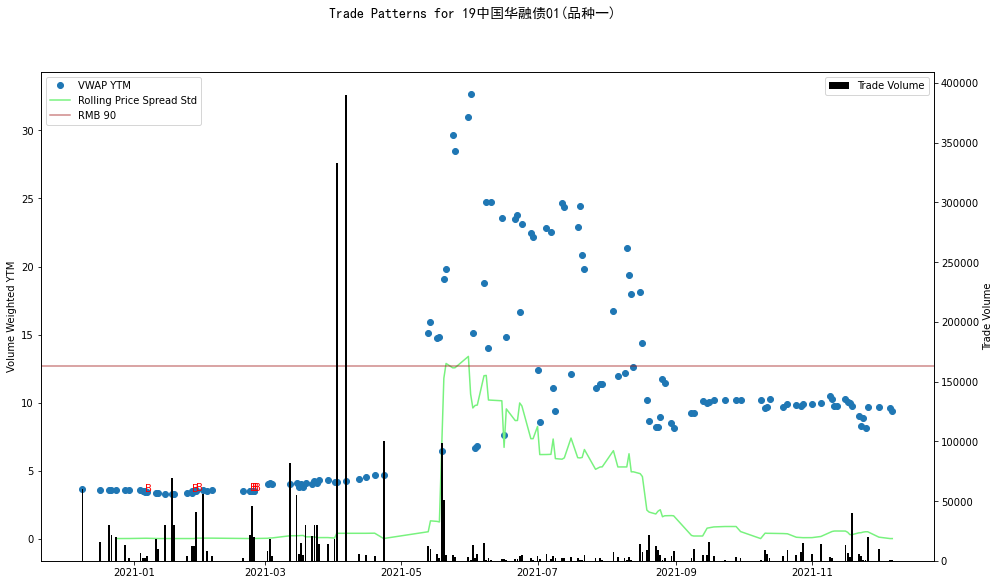

In [19]:
HR, tickers_HR, venues_HR = data_import("二级成交-中国华融资产管理股份有限公司(近一年)")
data, ticker_data =  plot_data_cleaning(HR, "19中国华融债01(品种一)")
make_pattern_graph(data,12.7,"19中国华融债01(品种一)",use_YTM=True, use_volume=True,std_plot=True)

* Step 4.2 判断适时的买回点位 - 价格分歧指数回落

    通过判断价格分歧指数的回落，即（成交最高价格-最低价格）连续五天的移动标准差，程序在7月中上旬以及8月初给出了买回信号。

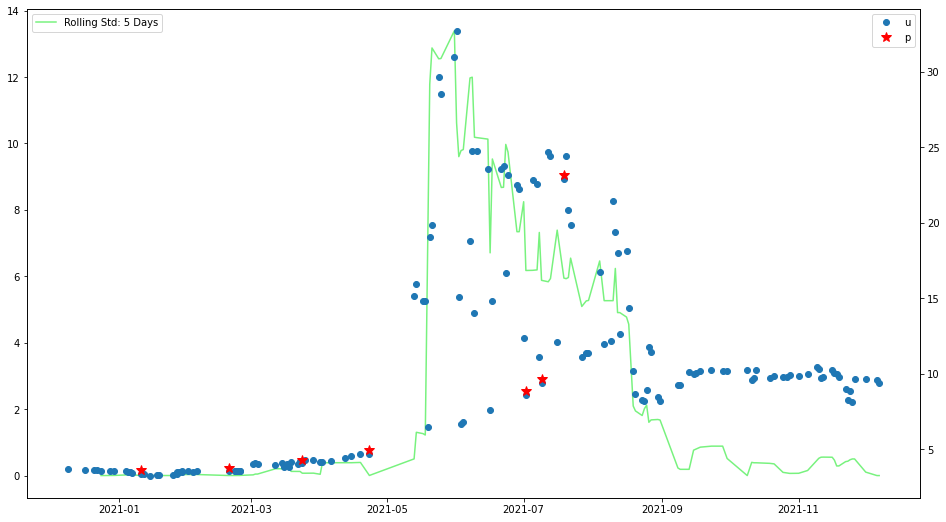

In [20]:
dev_buy_back(data,signal=True)

Step 4.2 判断适时的买回点位 - 成交YTM连续小幅下降

与成交YTM连续小幅上升相对应的是，通过判断成交YTM连续小幅下降（连续三天每天YTM成交下行10bp以上，目前价格尚处于93元以下）判断重新买回的点位，程序在7月上旬，8月上旬以及下旬给出了买回信号。

[Timestamp('2021-07-01 00:00:00'),
 Timestamp('2021-07-27 00:00:00'),
 Timestamp('2021-08-13 00:00:00')]

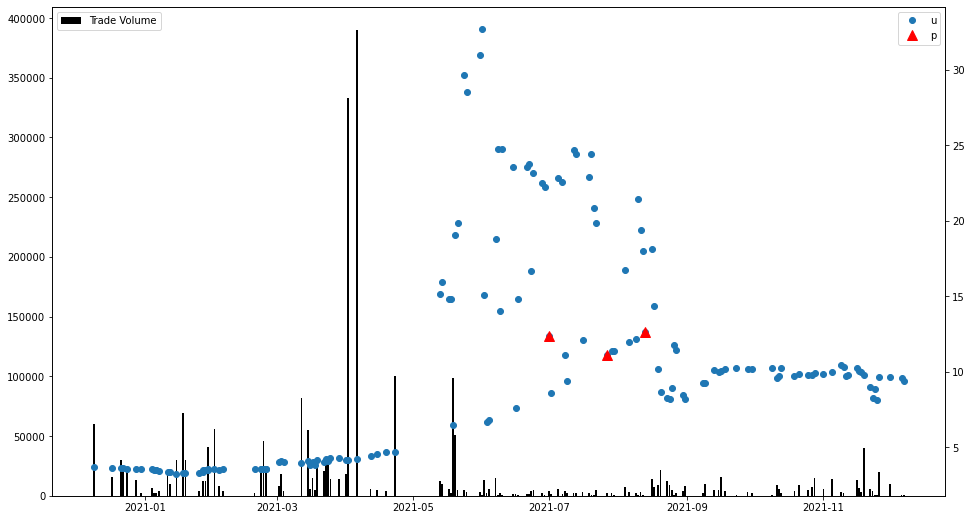

In [21]:
YTM_consec_decre(data,0.1,93)

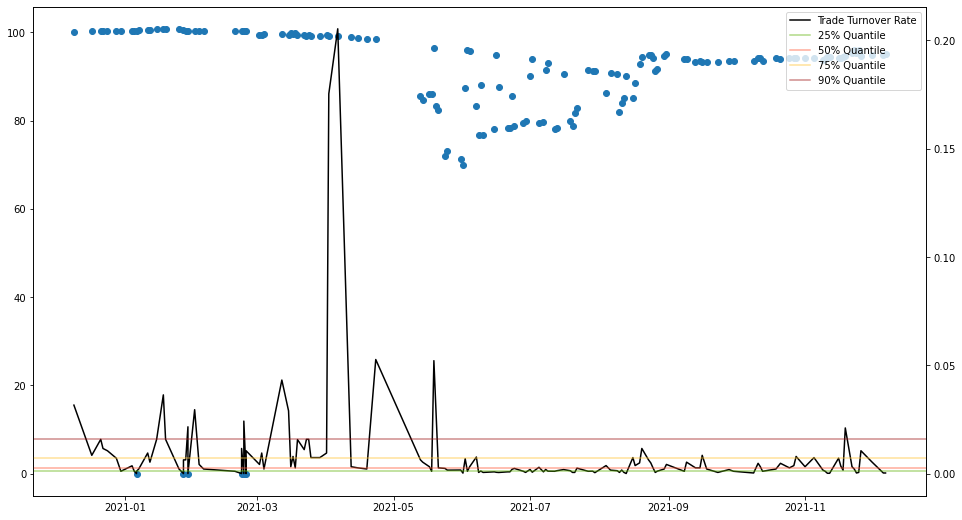

In [22]:
turn_over_plot(data,190,"CFETS")

@ copyrights Zhiwei Hu, The University of Chicago, First Created in 2021, Revised in 2022